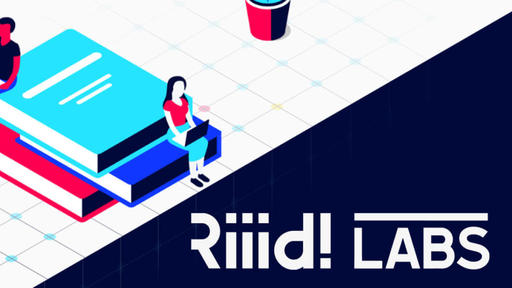

Your challenge is to create algorithms for "Knowledge Tracing," the modeling of student knowledge over time. The goal is to accurately predict how students will perform on future interactions. You will pair your machine learning skills using Riiid’s EdNet data.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
lect = pd.read_csv("/kaggle/input/riiid-test-answer-prediction/lectures.csv")
print(lect.shape)
ques = pd.read_csv("/kaggle/input/riiid-test-answer-prediction/questions.csv")
print(ques.shape)

## Libraries

In [ ]:
import dask.dataframe as dd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

Since the file is too large I am using Dask dataframe to read the train.csv

In [ ]:
%%time
train = dd.read_csv("/kaggle/input/riiid-test-answer-prediction/train.csv", low_memory=False)
print(str(len(train))+','+str(len(train.columns)))

## Sample Data

In [ ]:
train.head()

In [ ]:
user = train.groupby(train.user_id).user_id.count().compute()

### Total number of Users

In [ ]:
len(user)

In [ ]:
user.sort_values(ascending = False)
user_20 = user.nlargest(20)
user_20 = user_20.reset_index(name = 'counts')
user_20.user_id = user_20.user_id.astype('str')
row = user_20.user_id.tolist()
col = user_20.counts.tolist()
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
ax = sns.barplot(x="user_id", y="counts", data=user_20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Top 20 users')
plt.show()

### Total number of contents

In [ ]:
content = train.groupby(train.content_id).content_id.count().compute()
len(content)

In [ ]:
content.sort_values(ascending = False)
content_20 = content.nlargest(20)
content_20 = content_20.reset_index(name = 'counts')
content_20.content_id = content_20.content_id.astype('str')
row = content_20.content_id.tolist()
col = content_20.counts.tolist()
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
ax = sns.barplot(x="content_id", y="counts", data=content_20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Top 20 Contents')
plt.show()

In [ ]:
content_type = train.groupby(train.content_type_id).content_type_id.count().compute()
content_type = content_type.reset_index(name = 'count')
fig = px.pie(content_type, values='count', names='content_type_id', title='Content Type')
fig.show()

Only **2%** of Users watching the Lecture videos. **98%** Users exposed to the questions.

### Total number of Task Containers

In [ ]:
task_container = train.groupby(train.task_container_id).task_container_id.count().compute()
task_container.sort_values(ascending = False)
task_20 = task_container.nlargest(20)
task_20 = task_20.reset_index(name = 'counts')
task_20.task_container_id = task_20.task_container_id.astype('str')
print(len(task_container))

In [ ]:
row = task_20.task_container_id.tolist()
col = task_20.counts.tolist()
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
ax = sns.barplot(x="task_container_id", y="counts", data=task_20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Top 20 Task Containers')
plt.show()

In [ ]:
pr_question = train.groupby(train.prior_question_had_explanation).prior_question_had_explanation.count().compute()
pr_question = pr_question.reset_index(name = 'count')
fig = px.pie(pr_question, values='count', names='prior_question_had_explanation', title='Prior Question had Explanation Distribution')
fig.show()

**89%** previous questions had explanations.

In [ ]:
answered_correctly = train.groupby(train.answered_correctly).answered_correctly.count().compute()
answered_correctly = answered_correctly.reset_index(name = 'count')
fig = px.pie(answered_correctly, values='count', names='answered_correctly', title='Answered correctly Distribution')
fig.show()

**64.5%** Users provides the correct answers while **33.6%** provides wrong answers. 

In [ ]:
user_answer = train.groupby(train.user_answer).user_answer.count().compute()
user_answer = user_answer.reset_index(name = 'count')
fig = px.pie(user_answer, values='count', names='user_answer', title='User Answer Distribution')
fig.show()

In [ ]:
prior_question = train.groupby(train.prior_question_elapsed_time).prior_question_elapsed_time.count().compute()
prior_question.sort_values(ascending = False)
ques_20 = prior_question.nlargest(20)
ques_20 = ques_20.reset_index(name = 'counts')
ques_20.prior_question_elapsed_time = ques_20.prior_question_elapsed_time.astype('str')
ques_20.sort_values(by = 'counts', ascending= False)
print(len(prior_question))

In [ ]:
row = ques_20.prior_question_elapsed_time.tolist()
col = ques_20.counts.tolist()
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
ax = sns.barplot(x="prior_question_elapsed_time", y="counts", data=ques_20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Top 20 Time Consumption')
plt.show()

## Video Lectures

In [ ]:
lect.head()

In [ ]:
type_count = lect.groupby("type_of")['lecture_id'].count().reset_index(name = 'counts')
fig = px.pie(type_count, values='counts', names='type_of', title='Lecture Type Distribution')
fig.show()

In [ ]:
part_count = lect.groupby("part")['lecture_id'].count().reset_index(name = 'counts')
fig = px.pie(part_count, values='counts', names='part', title='Part Type Distribution')
fig.show()

In [ ]:
part_type = lect.groupby(["type_of","part"])["part"].count().reset_index(name = 'counts')
fig = px.scatter(part_type, x="part", y="type_of", size = 'counts')
fig.show()

In [ ]:
ques.head()

## Questions

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
cr = ques.groupby("correct_answer")['question_id'].count().reset_index(name = 'counts')
ax = sns.barplot(x="correct_answer", y="counts", data=cr)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
pr = ques.groupby("part")['question_id'].count().reset_index(name = 'counts')
ax = sns.barplot(x="part", y="counts", data=pr)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
tg = ques.groupby("tags")['question_id'].count().reset_index(name = 'counts')
tg = tg.sort_values(by = 'counts', ascending = False)
tg_20 = tg[:20]
ax = sns.barplot(x="tags", y="counts", data=tg_20)

In [ ]:
part_type = ques.groupby(["part","correct_answer"])["correct_answer"].count().reset_index(name = 'counts')
fig = px.scatter(part_type, x="part", y="correct_answer", size = 'counts')
fig.show()

If you <font color = 'orange'>like</font> this kernel and want to <font color = 'orange'>fork</font> plz <font color = 'red'><b>UPVOTE.</b></font>

If you have suggestions to improve this kernel plz <font color = 'red'>COMMENT.</font>

<font color = 'Orange'><b>************************ Notebook is under construction ************************</b></font>